# Autoencoder

## Czym jest autoencoder?

Autoencoder to **sieć neuronowa ucząca się bez nadzoru**, której celem jest
**odtworzenie danych wejściowych na wyjściu**.

Kluczowa idea:

* wejście = wyjście,
* sieć musi przejść przez **wąskie gardło (bottleneck)**,
* w tym miejscu wymuszona jest **kompresja informacji**.

Autoencoder składa się z trzech części:

1. **Encoder** – kompresuje dane i wydobywa cechy
2. **Bottleneck (latent space)** – skompresowana reprezentacja
3. **Decoder** – rekonstruuje dane z tej reprezentacji

![AE](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

---

## Do czego wykorzystuje się autoencodery?

Autoencodery są używane m.in. do:

* redukcji wymiarowości (alternatywa dla PCA),
* odszumiania obrazów (denoising autoencoder),
* wykrywania anomalii,
* uczenia reprezentacji danych,
* jako punkt wyjścia do architektur typu **U-Net**.

---

## Import bibliotek

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

## Przygotowanie danych (MNIST)

Używamy zbioru MNIST:

* obrazy cyfr 28×28,
* **etykiety nie są potrzebne**, bo autoencoder uczy się bez nadzoru.

In [3]:
# Zamieniamy obrazy na tensory o wartościach w [0, 1]
transform = transforms.Compose([
    transforms.ToTensor()
])

# Zbiór treningowy MNIST
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

# DataLoader – podaje dane w paczkach (batchach)
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)

100%|██████████| 9.91M/9.91M [00:09<00:00, 1.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 235kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.58MB/s]


## Definicja architektury autoencodera

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        # Zmniejsza wymiar danych wejściowych
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),  # obraz -> wektor
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )

        # Bottleneck (latent space)
        # Wąskie gardło – tu następuje kompresja
        self.bottleneck = nn.Linear(64, 16)

        # Decoder
        # Odtwarza dane z reprezentacji ukrytej
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()  # wartości pikseli w [0, 1]
        )

    def forward(self, x):
        # Spłaszczamy obraz: (batch, 1, 28, 28) -> (batch, 784)
        x = x.view(x.size(0), -1)

        # Kodowanie (kompresja)
        z = self.encoder(x)
        z = self.bottleneck(z)

        # Dekodowanie (rekonstrukcja)
        x_hat = self.decoder(z)

        return x_hat

## Inicjalizacja modelu i uczenie

In [5]:
# Wybór urządzenia (CPU / GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)

# Funkcja straty – błąd rekonstrukcji
# Porównujemy obraz wejściowy z odtworzonym
criterion = nn.MSELoss()

# Optymalizator
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Pętla treningowa

In [6]:
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0

    for images, _ in train_loader:
        images = images.to(device)

        # Przejście w przód
        outputs = model(images)

        # Porównujemy rekonstrukcję z wejściem
        loss = criterion(
            outputs,
            images.view(images.size(0), -1)
        )

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Loss: {total_loss / len(train_loader):.4f}"
    )

Epoch [1/10], Loss: 0.0519
Epoch [2/10], Loss: 0.0267
Epoch [3/10], Loss: 0.0212
Epoch [4/10], Loss: 0.0183
Epoch [5/10], Loss: 0.0166
Epoch [6/10], Loss: 0.0155
Epoch [7/10], Loss: 0.0144
Epoch [8/10], Loss: 0.0136
Epoch [9/10], Loss: 0.0129
Epoch [10/10], Loss: 0.0124


## Wizualizacja wyników: oryginał vs rekonstrukcja

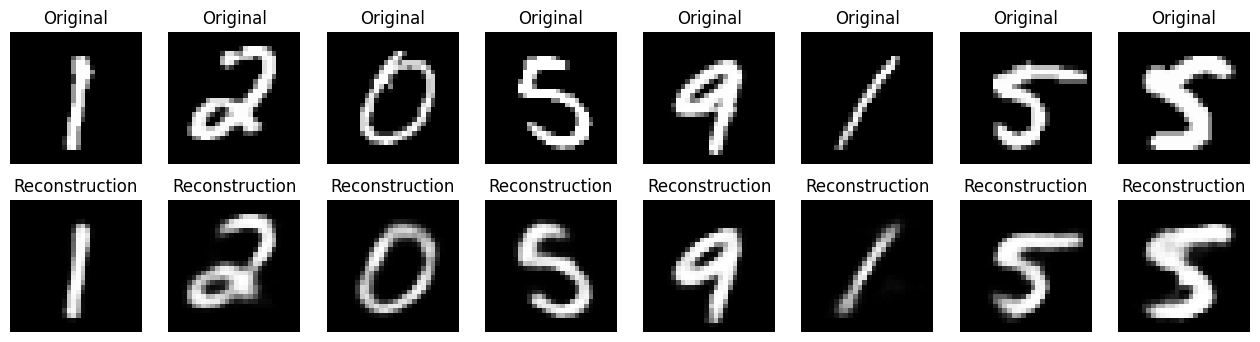

In [7]:
model.eval()

images, _ = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():
    reconstructions = model(images)

n = 8
plt.figure(figsize=(16, 4))

for i in range(n):
    # Oryginalny obraz
    plt.subplot(2, n, i + 1)
    plt.imshow(images[i].cpu().view(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Rekonstrukcja
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructions[i].cpu().view(28, 28), cmap="gray")
    plt.title("Reconstruction")
    plt.axis("off")

plt.show()